In [1]:
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('[YOUR_DIRECTORY_HERE]/panoptic-dark-16_9.mplstyle')

In [2]:
dir = "[YOUR_DIRECTORY_TO_SAVE_TO_HERE]/"

In [3]:
query_initial = gql("""
    query GetPositionSnapshots($lastID: String) {
        positionSnapshots(first: 1, orderBy: position__leverage, orderDirection: desc) {
            id
            timestamp
            position {
                timestampOpened
                timestampClosed
                asset {
                    id
                }
                realisedPnlUSD
                side
                leverage
            }
        }
    }
""")

query = gql("""
    query GetPositionSnapshots($lastID: String) {
        positionSnapshots(first: 1000, where: { id_gt: $lastID }, orderBy: position__leverage, orderDirection: desc) {
            id
            timestamp
            position {
                timestampOpened
                timestampClosed
                asset {
                    id
                }
                asset
                balanceUSD
                collateralBalanceUSD
                realisedPnlUSD
                side
                leverage
            }
        }
    }
""")

In [4]:
# Connects to the Messari GMX Arbitrum subgraph
client = Client(
 transport=RequestsHTTPTransport(
 url='https://api.thegraph.com/subgraphs/name/messari/gmx-arbitrum',
 verify=True,
 retries=5,
 ))


all_results = []
last_id = None
while True:
    if last_id is None:
        my_query = query_initial
    else:
        my_query = query

    params = {"lastID": last_id}
    try:
        result = client.execute(my_query, variable_values=params)
        # print(result)
    except Exception as ex:
        print("got exception while querying data:", ex)
        raise BaseException("Exception while querying data:", ex)

    # check if there are no more results
    if not result["positionSnapshots"]:
        break

    all_results.extend(result["positionSnapshots"])
    last_id = result["positionSnapshots"][-1]["id"]

In [5]:
# Number of open and closed positions
len(all_results)

73137

In [6]:
# Convert data to pandas dataframe
def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

# Flatten dictionaries in the list
all_results_flat = [flatten_dict(item) for item in all_results]

df = pd.DataFrame(all_results_flat)
df

,id,timestamp,position_timestampOpened,position_timestampClosed,position_asset_id,position_realisedPnlUSD,position_side,position_leverage,position_balanceUSD,position_collateralBalanceUSD
0,0xee37426bdcb57844dbd084ce8a7e91e1b191fd1b489e...,1684447238,1684447135,None,0x82af49447d8a07e3bd95bd0d56f35241523fbab1,None,SHORT,98.35180000000000000000000000000032,NaN,NaN
1,0xf17f5263c6c14bf39b27d2f6401b07fdb961f9b4489e...,1684433303,1684433303,None,0x2f2a2543b76a4166549f7aab2e75bef0aefc5b0f,None,LONG,50.03888732946467929632192798135944,2009.1962272488,40.1526959226712
2,0xfcd5a0fa75b0127acacf63f1c25cb4de42f44bfd489e...,1684440928,1684434009,None,0xf97f4df75117a78c1a5a0dbb814af92458539fb4,None,LONG,50.00714063159721751631148027609001,28971.21468709825142855974860618,579.341556449493739963741273551482
3,0xfcd5a0fa75b0127acacf63f1c25cb4de42f44bfd489e...,1684436824,1684434009,None,0xf97f4df75117a78c1a5a0dbb814af92458539fb4,None,LONG,50.00714063159721751631148027609001,28971.21468709825142855974860618,579.341556449493739963741273551482
4,0xfcd5a0fa75b0127acacf63f1c25cb4de42f44bfd489e...,1684441471,1684434009,None,0xf97f4df75117a78c1a5a0dbb814af92458539fb4,None,LONG,50.00714063159721751631148027609001,28971.21468709825142855974860618,579.341556449493739963741273551482
...,...,...,...,...,...,...,...,...,...,...
73132,0xffffbdea9371fef6f43c9fa89fa172e58eec7e8d489e...,1667030381,1667030381,1667030675,0x82af49447d8a07e3bd95bd0d56f35241523fbab1,0.00912369532339846066611344063,LONG,0,0,0
73133,0xffffbdea9371fef6f43c9fa89fa172e58eec7e8d489e...,1667030359,1667030338,1667030359,0x82af49447d8a07e3bd95bd0d56f35241523fbab1,0.041087036621727552865605135628,LONG,0,0,0
73134,0xffffbdea9371fef6f43c9fa89fa172e58eec7e8d489e...,1667030675,1667030381,1667030675,0x82af49447d8a07e3bd95bd0d56f35241523fbab1,0.00912369532339846066611344063,LONG,0,0,0
73135,0xffffbdea9371fef6f43c9fa89fa172e58eec7e8d489e...,1667030381,1667030381,1667030675,0x82af49447d8a07e3bd95bd0d56f35241523fbab1,0.00912369532339846066611344063,LONG,0,0,0


In [7]:
for col in ['position_realisedPnlUSD', 'position_leverage', 'position_balanceUSD', 'position_collateralBalanceUSD']:
    df[col] = df[col].astype(float)

3012


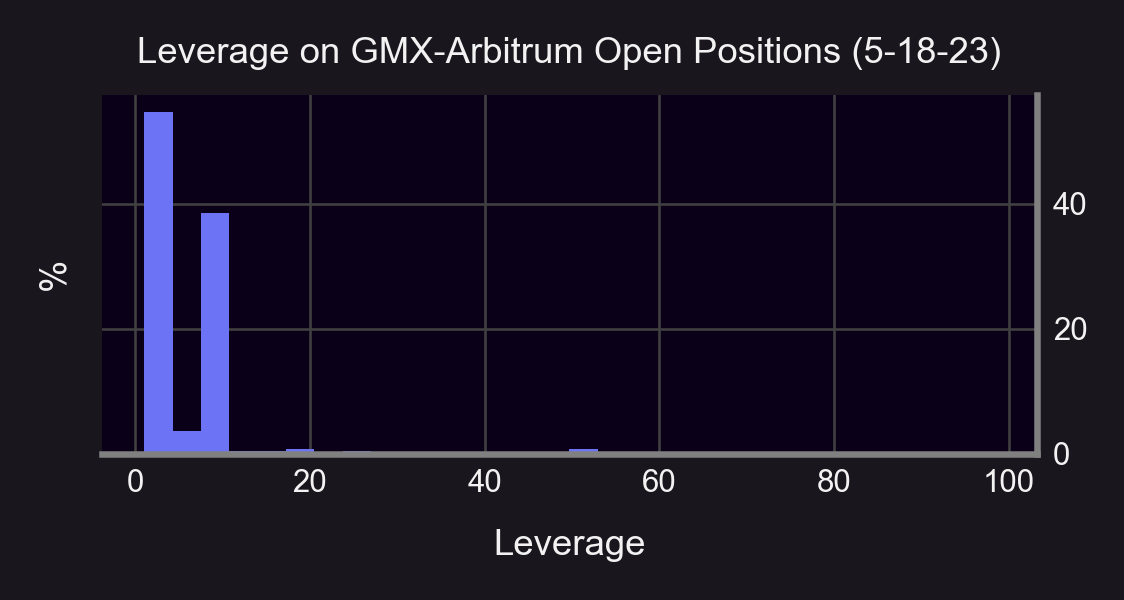

In [8]:
open_trades = df[df['position_timestampClosed'].isnull()]
print(len(open_trades))

weights = (np.ones_like(open_trades['position_leverage']) / len(open_trades['position_leverage'])) * 100
counts, bins, patches = plt.hist(open_trades['position_leverage'], bins=30, weights=weights)

plt.ylabel('%')
plt.xlabel('Leverage')
plt.title('Leverage on GMX-Arbitrum Open Positions (5-18-23)')
plt.savefig(f'{dir}leverage-gmx-arbitrum-5-18-23')
plt.show()

2915


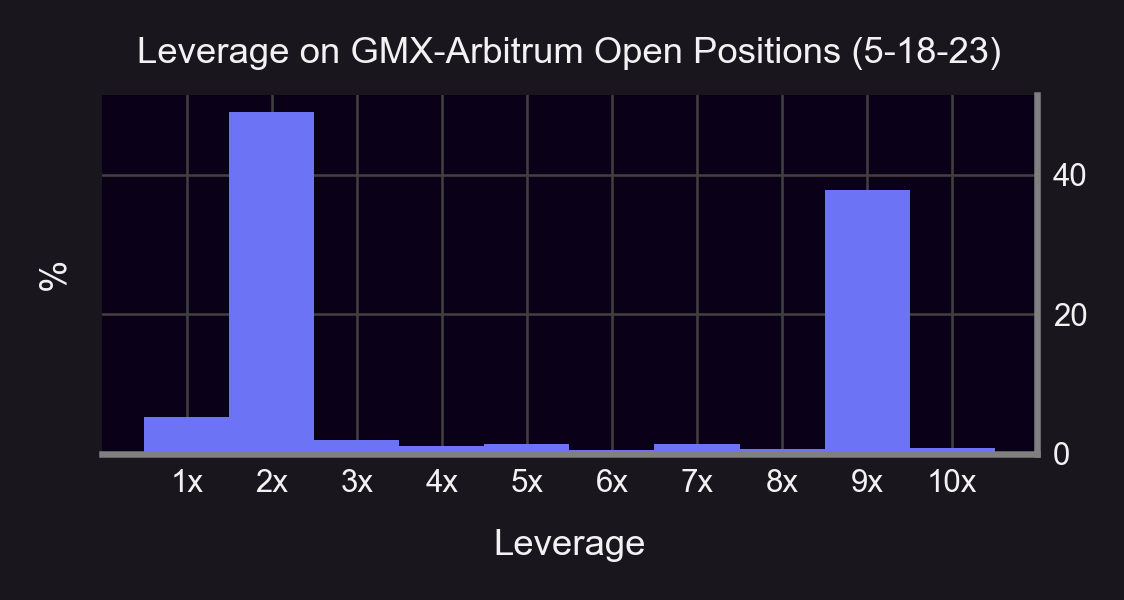

In [9]:
open_trades = df[(df['position_timestampClosed'].isnull()) & (df.position_leverage <= 11)]
print(len(open_trades))

bin_edges = range(1, 12)
weights = (np.ones_like(open_trades['position_leverage']) / len(open_trades['position_leverage'])) * 100
counts, bins, patches = plt.hist(open_trades['position_leverage'], bins=bin_edges, weights=weights)
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.xticks(bin_centers, labels=[f"{b:.0f}x" for b in bins[:10]], rotation=0)
plt.ylabel('%')
plt.xlabel('Leverage')
plt.title('Leverage on GMX-Arbitrum Open Positions (5-18-23)')
plt.savefig(f'{dir}leverage-gmx-arbitrum-5-18-23_zoom.png')
plt.show()